# Practice Session PS05: Recommendation engines (Content-based)

Author: <font color="blue">Leticia Martin Cabrera</font>

E-mail: <font color="blue">leticia.martin03@estudiant.upf.edu</font>

Date: <font color="blue">08/11/2021</font>

In [1]:
pip install wordCloud

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np  
import matplotlib.pyplot as plt  
import pandas as pd   
from math import*
import seaborn as sns
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# 1. Load and join the dataset

In [3]:
# Leave this code as-is

FILENAME_RATINGS = "data/ratings.dat"
FILENAME_USERS = "data/users.dat"
FILENAME_MOVIES = "data/movies.dat"

In [4]:
# Leave this code as-is

ratings_raw = pd.read_csv(FILENAME_RATINGS, 
                    sep='::', 
                    encoding='latin-1',
                    engine='python',
                    names=['user_id', 'movie_id', 'rating', 'timestamp'])

users = pd.read_csv(FILENAME_USERS, 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['user_id', 'gender', 'age', 'occupation', 'zipcode'])
users.set_index('user_id')

movies = pd.read_csv(FILENAME_MOVIES, 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['movie_id', 'title', 'genres'])
movies.set_index('movie_id')

,title,genres
movie_id,,
1,Toy Story (1995),Animation|Children's|Comedy
2,Jumanji (1995),Adventure|Children's|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama
5,Father of the Bride Part II (1995),Comedy
...,...,...
3948,Meet the Parents (2000),Comedy
3949,Requiem for a Dream (2000),Drama
3950,Tigerland (2000),Drama


In [5]:
#Indicate the number of rows and print the five records of each file
print("############ RATINGS FILE ############")
print("Rows:", ratings_raw.shape[0])
print(ratings_raw.head(5))
print("\n############ USERS FILE ############")
print("Rows:", users.shape[0])
print(users.head(5))
print("\n############ MOVIES FILE ############")
print("Rows:", movies.shape[0])
print(movies.head(5))

############ RATINGS FILE ############
Rows: 1000209
   user_id  movie_id  rating  timestamp
0        1      1193       5  978300760
1        1       661       3  978302109
2        1       914       3  978301968
3        1      3408       4  978300275
4        1      2355       5  978824291

############ USERS FILE ############
Rows: 6040
   user_id gender  age  occupation zipcode
0        1      F    1          10   48067
1        2      M   56          16   70072
2        3      M   25          15   55117
3        4      M   45           7   02460
4        5      M   25          20   55455

############ MOVIES FILE ############
Rows: 3883
   movie_id                               title                        genres
0         1                    Toy Story (1995)   Animation|Children's|Comedy
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
2         3             Grumpier Old Men (1995)                Comedy|Romance
3         4            Waiting to Exha

Ratings_raw and Users files have the field user_id in common so we can joined them. The files of ratings_raw and movies have the column movie_id in common so we can also joined into a new dataframe. 

In [6]:
# joining the datasets into a single dataframe named "ratings"
ratings = pd.merge(ratings_raw, users, how='inner', on='user_id')
ratings = pd.merge(ratings, movies, how= 'inner', on = 'movie_id')
ratings.head()

,user_id,movie_id,rating,timestamp,gender,age,occupation,zipcode,title,genres
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,M,56,16,70072,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,M,25,12,32793,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,M,25,7,22903,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,M,50,1,95350,One Flew Over the Cuckoo's Nest (1975),Drama


In [7]:
#create find_movies function
def find_movies(keyword, dataset):
    for movie in dataset['title']: 
        if keyword in movie:
            result = dataset['movie_id'][dataset['title'] == movie].iloc[0]  #obtaining movie_id of the selected movie 
            print("movie_id:", result, ", title:", movie ) 

In [8]:
find_movies("Godfather", movies)

movie_id: 858 , title: Godfather, The (1972)
movie_id: 1221 , title: Godfather: Part II, The (1974)
movie_id: 2023 , title: Godfather: Part III, The (1990)


# 2. Exploratory Data Analysis

## 2.1. "Ratings" variable

In [9]:
# Leave this code as-is
ratings['rating'].describe()

count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

Text(0, 0.5, 'Probabilities')

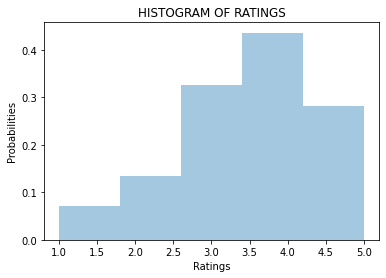

In [10]:
#plot a histogram of ratings
sns.distplot (ratings["rating"], kde = False, bins = 5 ,norm_hist = True)
plt.title ("HISTOGRAM OF RATINGS")
plt.xlabel ("Ratings")
plt.ylabel ("Probabilities")

We can observe that more than 70% of the movies are rated at least with 4 stars. Also, it shows that less than 10% are rated with one star.  

## 2.2. Gender differences in rating

In [11]:
#creating two dataframes
ratings_f = ratings[ratings['gender'] == 'F']
ratings_m = ratings[ratings['gender'] == 'M']

#creating two columns for count and mean in each dataframe
ratings_f = ratings_f.groupby('movie_id').rating.agg(['count','mean'])
ratings_m = ratings_m.groupby('movie_id').rating.agg(['count','mean'])

#Select at leat 100 movies rated from men and women
ratings_f = ratings_f[ratings_f['count'] >= 100]
ratings_m = ratings_m[ratings_m['count'] >= 100]

#rename the columns count and mean of each dataframe
ratings_f = ratings_f.rename(columns={'count': 'ratings_count_f', 'mean': 'ratings_mean_f'})
ratings_m = ratings_m.rename(columns={'count': 'ratings_count_m', 'mean': 'ratings_mean_m'})

#joining dataframe of men and women
ratings_diff = pd.merge(ratings_f, ratings_m, how= 'inner', on= 'movie_id')

#create a new column with absolute difference in ratings
ratings_diff['ratings_diff'] = abs(ratings_diff['ratings_mean_m']- ratings_diff['ratings_mean_f'])
#sorts the dataframe by ratings_diff in ascending ordering
ratings_diff = ratings_diff.sort_values(by='ratings_diff', ascending=False)
ratings_diff.head() #print the first five movies

,ratings_count_f,ratings_mean_f,ratings_count_m,ratings_mean_m,ratings_diff
movie_id,,,,,
1088,291,3.790378,396,2.959596,0.830782
2468,106,3.254717,268,2.578358,0.676359
231,149,2.697987,511,3.336595,0.638608
1380,283,3.975265,534,3.367041,0.608224
3552,207,3.396135,760,3.969737,0.573602


Once we have observed the result, we can conclude that there are more number of ratings from men than from women. In addition, We note that there is a difference of at least 0.5 between the rating of men and women.

## 2.3. Genres distribution

In [12]:
#creating a lit with all genres in the dataset
movie_genres = [] #list with 18 different type of genres
all_genres = [] #list with all genres for each movie. I need it to do the next exercise.
for genres in movies['genres']:
    list_genres = genres.split('|')
    all_genres.append(list_genres)
    for genre in list_genres:
        if genre not in movie_genres:
            movie_genres.append(genre)
            
print("There are",len(movie_genres), "genres")

There are 18 genres


In [13]:
#Create a list with the frequency of each genre
keyword_occurences = dict.fromkeys(movie_genres,0)  #creating a dicctionay with all 18 genres as keys. 
#Calculating the frequency of the genres
for genre in movie_genres:
    for i in all_genres: 
        if genre in i:
            keyword_occurences[genre] +=  1

keyword_occurences = sorted(keyword_occurences.items(),key=lambda x:x[1], reverse= True ) #sorting the dictionary. It returns a list containing tuples
#converting the tuple in list
for i in range(len(keyword_occurences)): 
    keyword_occurences[i] = list(keyword_occurences[i])
    
keyword_occurences

[['Drama', 1603],
 ['Comedy', 1200],
 ['Action', 503],
 ['Thriller', 492],
 ['Romance', 471],
 ['Horror', 343],
 ['Adventure', 283],
 ['Sci-Fi', 276],
 ["Children's", 251],
 ['Crime', 211],
 ['War', 143],
 ['Documentary', 127],
 ['Musical', 114],
 ['Mystery', 106],
 ['Animation', 105],
 ['Fantasy', 68],
 ['Western', 68],
 ['Film-Noir', 44]]

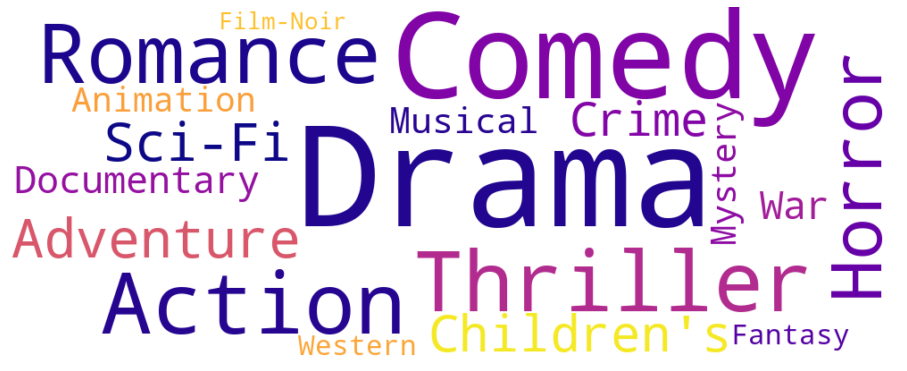

In [14]:
# Change the colors/style if you want

# Generate the word cloud
genre_wordcloud = WordCloud(width=1000, height=400, background_color='white', colormap= 'plasma')
genre_wordcloud.generate_from_frequencies(dict(keyword_occurences))

# Plot the word cloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Observing this word cloud, we can conclude that the word with larger size are the most frequent movie genres whereas the genres less frequently appear smaller. Therefore, Comedy and Drama are the most frequent genres whereas Fantasy and Film-Noir are the less ones.

# 3. Content-based recommendation

## 3.1. Compute TF-IDF vectors

In [15]:
#Adding a new column to movies dataframe
movies['genres_arr'] = all_genres 
movies['genres_arr']= movies['genres_arr'].fillna('').astype('str')
movies   

,movie_id,title,genres,genres_arr
0,1,Toy Story (1995),Animation|Children's|Comedy,"['Animation', ""Children's"", 'Comedy']"
1,2,Jumanji (1995),Adventure|Children's|Fantasy,"['Adventure', ""Children's"", 'Fantasy']"
2,3,Grumpier Old Men (1995),Comedy|Romance,"['Comedy', 'Romance']"
3,4,Waiting to Exhale (1995),Comedy|Drama,"['Comedy', 'Drama']"
4,5,Father of the Bride Part II (1995),Comedy,['Comedy']
...,...,...,...,...
3878,3948,Meet the Parents (2000),Comedy,['Comedy']
3879,3949,Requiem for a Dream (2000),Drama,['Drama']
3880,3950,Tigerland (2000),Drama,['Drama']
3881,3951,Two Family House (2000),Drama,['Drama']


In [16]:
# Leave this code as-is

print("Transformed: %s → %s" % (movies['genres'][0], movies['genres_arr'][0]))

Transformed: Animation|Children's|Comedy → ['Animation', "Children's", 'Comedy']


In [17]:
#Generate "tfidf_matrix"
vectorizer = TfidfVectorizer(ngram_range=(1,2))
tfidf_matrix = vectorizer.fit_transform(movies['genres_arr']) #create the matrix
print('Tfidf_matrix has',tfidf_matrix.shape[0],'rows and',tfidf_matrix.shape[1], 'columns') #shape of the matrix

Tfidf_matrix has 3883 rows and 127 columns


## 3.2. Calculate most similar movies

In [18]:
# Leave this code as-is

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
print(cosine_sim)

[[1.         0.14193614 0.09010857 ... 0.         0.         0.        ]
 [0.14193614 1.         0.         ... 0.         0.         0.        ]
 [0.09010857 0.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         1.         0.3165589 ]
 [0.         0.         0.         ... 1.         1.         0.3165589 ]
 [0.         0.         0.         ... 0.3165589  0.3165589  1.        ]]


In [19]:
# Leave this code as-is

# Create an index to convert from numbers to movie_id
movie_id_to_index = pd.Series(movies.index, index=movies['movie_id'])

# Print the similarity vector
def print_similarity_vector(movie_id, similarities):
    
    # Determine the index of the movie_id
    index_source = movie_id_to_index[movie_id]
    
    # Get the row in the similarities matrix
    sim_scores = list(similarities[index_source])

    # Iterate through that row
    for index_target in range(len(sim_scores)):
        print("%.3f %d %s" %
              (sim_scores[index_target], movies.iloc[index_target].movie_id, movies.iloc[index_target].title))
        
print_similarity_vector(1, cosine_sim)

1.000 1 Toy Story (1995)
0.142 2 Jumanji (1995)
0.090 3 Grumpier Old Men (1995)
0.106 4 Waiting to Exhale (1995)
0.235 5 Father of the Bride Part II (1995)
0.000 6 Heat (1995)
0.090 7 Sabrina (1995)
0.210 8 Tom and Huck (1995)
0.000 9 Sudden Death (1995)
0.000 10 GoldenEye (1995)
0.073 11 American President, The (1995)
0.074 12 Dracula: Dead and Loving It (1995)
0.827 13 Balto (1995)
0.000 14 Nixon (1995)
0.000 15 Cutthroat Island (1995)
0.000 16 Casino (1995)
0.000 17 Sense and Sensibility (1995)
0.000 18 Four Rooms (1995)
0.235 19 Ace Ventura: When Nature Calls (1995)
0.000 20 Money Train (1995)
0.065 21 Get Shorty (1995)
0.000 22 Copycat (1995)
0.000 23 Assassins (1995)
0.000 24 Powder (1995)
0.000 25 Leaving Las Vegas (1995)
0.000 26 Othello (1995)
0.000 27 Now and Then (1995)
0.000 28 Persuasion (1995)
0.000 29 City of Lost Children, The (1995)
0.000 30 Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
0.000 31 Dangerous Minds (1995)
0.000 32 Twelve Monkeys (1995)
0.000 33 Wing

In [20]:
def genre_content_based_recommendations(movie_id, movies, similarities, num_movies=10):

    index_source = movie_id_to_index[movie_id]

    # Computing top_similarities
    enumerated = list(enumerate(similarities[index_source]))
    sorted_similarities = sorted(enumerated, key=lambda x: x[1], reverse=True)
    top_similarities =sorted_similarities[0:num_movies]
    
    recommendations = []
    for (index_target, similarity) in top_similarities:

        movie_id = movies.iloc[index_target].movie_id
        title =  movies.iloc[index_target].title
        genres =  movies.iloc[index_target].genres
        recommendations.append({
                'movie_id': movie_id,
                'title': title,
                'genres': genres,
                'similarity': similarity
            }
        )

    return pd.DataFrame.from_records(recommendations, columns=['similarity', 'movie_id', 'title', 'genres'])

In [21]:
#printing the top 15 recommendations for musical movie "Grease" 
genre_content_based_recommendations(1380, movies, cosine_sim, num_movies = 15)

,similarity,movie_id,title,genres
0,1.000000,907,"Gay Divorcee, The (1934)",Comedy|Musical|Romance
1,1.000000,945,Top Hat (1935),Comedy|Musical|Romance
2,1.000000,1057,Everyone Says I Love You (1996),Comedy|Musical|Romance
3,1.000000,1066,Shall We Dance? (1937),Comedy|Musical|Romance
4,1.000000,1067,"Damsel in Distress, A (1937)",Comedy|Musical|Romance
5,1.000000,1380,Grease (1978),Comedy|Musical|Romance
6,1.000000,1381,Grease 2 (1982),Comedy|Musical|Romance
7,1.000000,3199,Pal Joey (1957),Comedy|Musical|Romance
8,0.812324,899,Singin' in the Rain (1952),Musical|Romance
9,0.812324,900,"American in Paris, An (1951)",Musical|Romance


In [22]:
#print the top 15 recommendations for sci-fi movie "Alien" 
genre_content_based_recommendations(1214, movies, cosine_sim, num_movies = 15)


,similarity,movie_id,title,genres
0,1.000000,1214,Alien (1979),Action|Horror|Sci-Fi|Thriller
1,1.000000,1320,Alien³ (1992),Action|Horror|Sci-Fi|Thriller
2,1.000000,2288,"Thing, The (1982)",Action|Horror|Sci-Fi|Thriller
3,0.888636,611,Hellraiser: Bloodline (1996),Action|Horror|Sci-Fi
4,0.888636,1690,Alien: Resurrection (1997),Action|Horror|Sci-Fi
5,0.888636,1762,Deep Rising (1998),Action|Horror|Sci-Fi
6,0.888636,2525,Alligator (1980),Action|Horror|Sci-Fi
7,0.888636,2613,Night of the Comet (1984),Action|Horror|Sci-Fi
8,0.888636,2614,Chopping Mall (a.k.a. Killbots) (1986),Action|Horror|Sci-Fi
9,0.888636,3576,"Hidden, The (1987)",Action|Horror|Sci-Fi


In [23]:
#Obtaining the movie_of of three movies
find_movies("Apocalypse", movies)
find_movies('Vita', movies)
find_movies('Godfather', movies)

movie_id: 1208 , title: Apocalypse Now (1979)
movie_id: 2324 , title: Life Is Beautiful (La Vita è bella) (1997)
movie_id: 858 , title: Godfather, The (1972)
movie_id: 1221 , title: Godfather: Part II, The (1974)
movie_id: 2023 , title: Godfather: Part III, The (1990)


In [24]:
#print the top 10 recommendations of "Apocalypse Now (1979)" 
recomendations1 = genre_content_based_recommendations(1208, movies, cosine_sim, num_movies = 10)
recomendations1

,similarity,movie_id,title,genres
0,1.0,41,Richard III (1995),Drama|War
1,1.0,155,Beyond Rangoon (1995),Drama|War
2,1.0,336,"Walking Dead, The (1995)",Drama|War
3,1.0,527,Schindler's List (1993),Drama|War
4,1.0,647,Courage Under Fire (1996),Drama|War
5,1.0,979,Nothing Personal (1995),Drama|War
6,1.0,991,Michael Collins (1996),Drama|War
7,1.0,1090,Platoon (1986),Drama|War
8,1.0,1178,Paths of Glory (1957),Drama|War
9,1.0,1208,Apocalypse Now (1979),Drama|War


In [25]:
#Create a new column indicating if the results is relevant or irrelevant 
recomendations1['relevancy'] = ['irrelevant', 'irrelevant' ,'irrelevant', 'relevant', 'relevant','irrelevant', 'irrelevant', 'relevant','relevant', 'relevant' ]
#compute the precision
precision = sum(recomendations1['relevancy'] == 'relevant')/len(recomendations1['relevancy'])
print("The precision is:", precision)
recomendations1


The precision is: 0.5


,similarity,movie_id,title,genres,relevancy
0,1.0,41,Richard III (1995),Drama|War,irrelevant
1,1.0,155,Beyond Rangoon (1995),Drama|War,irrelevant
2,1.0,336,"Walking Dead, The (1995)",Drama|War,irrelevant
3,1.0,527,Schindler's List (1993),Drama|War,relevant
4,1.0,647,Courage Under Fire (1996),Drama|War,relevant
5,1.0,979,Nothing Personal (1995),Drama|War,irrelevant
6,1.0,991,Michael Collins (1996),Drama|War,irrelevant
7,1.0,1090,Platoon (1986),Drama|War,relevant
8,1.0,1178,Paths of Glory (1957),Drama|War,relevant
9,1.0,1208,Apocalypse Now (1979),Drama|War,relevant


In [26]:
#print the top 10 recommendations of  Life Is Beautiful (La Vita è bella) (1997)" 
recomendations2 = genre_content_based_recommendations(2324, movies, cosine_sim, num_movies = 10)
recomendations2

,similarity,movie_id,title,genres
0,1.0,4,Waiting to Exhale (1995),Comedy|Drama
1,1.0,45,To Die For (1995),Comedy|Drama
2,1.0,72,Kicking and Screaming (1995),Comedy|Drama
3,1.0,75,Big Bully (1996),Comedy|Drama
4,1.0,84,Last Summer in the Hamptons (1995),Comedy|Drama
5,1.0,106,Nobody Loves Me (Keiner liebt mich) (1994),Comedy|Drama
6,1.0,133,Nueba Yol (1995),Comedy|Drama
7,1.0,166,"Doom Generation, The (1995)",Comedy|Drama
8,1.0,205,Unstrung Heroes (1995),Comedy|Drama
9,1.0,218,Boys on the Side (1995),Comedy|Drama


In [27]:
#Create a new column indicating if the results is relevant or irrelevant 
recomendations2['relevancy'] = ['irrelevant', 'irrelevant' ,'irrelevant', 'irrelevant', 'irrelevant','relevant', 'relevant', 'relevant','irrelevant', 'relevant' ]
#compute the precision
precision = sum(recomendations2['relevancy'] == 'relevant')/len(recomendations2['relevancy'])
print("The precision is:", precision)
recomendations2

The precision is: 0.4


,similarity,movie_id,title,genres,relevancy
0,1.0,4,Waiting to Exhale (1995),Comedy|Drama,irrelevant
1,1.0,45,To Die For (1995),Comedy|Drama,irrelevant
2,1.0,72,Kicking and Screaming (1995),Comedy|Drama,irrelevant
3,1.0,75,Big Bully (1996),Comedy|Drama,irrelevant
4,1.0,84,Last Summer in the Hamptons (1995),Comedy|Drama,irrelevant
5,1.0,106,Nobody Loves Me (Keiner liebt mich) (1994),Comedy|Drama,relevant
6,1.0,133,Nueba Yol (1995),Comedy|Drama,relevant
7,1.0,166,"Doom Generation, The (1995)",Comedy|Drama,relevant
8,1.0,205,Unstrung Heroes (1995),Comedy|Drama,irrelevant
9,1.0,218,Boys on the Side (1995),Comedy|Drama,relevant


In [28]:
#print the top 10 recommendations of Godfather, The (1972)" 
recomendations3 = genre_content_based_recommendations(858, movies, cosine_sim, num_movies = 10)
recomendations3

,similarity,movie_id,title,genres
0,1.000000,42,Dead Presidents (1995),Action|Crime|Drama
1,1.000000,493,Menace II Society (1993),Action|Crime|Drama
2,1.000000,858,"Godfather, The (1972)",Action|Crime|Drama
3,1.000000,1221,"Godfather: Part II, The (1974)",Action|Crime|Drama
4,1.000000,2023,"Godfather: Part III, The (1990)",Action|Crime|Drama
5,1.000000,2194,"Untouchables, The (1987)",Action|Crime|Drama
6,1.000000,2912,"Limey, The (1999)",Action|Crime|Drama
7,0.848618,1953,"French Connection, The (1971)",Action|Crime|Drama|Thriller
8,0.848618,2540,"Corruptor, The (1999)",Action|Crime|Drama|Thriller
9,0.825405,284,New York Cop (1996),Action|Crime


In [29]:
#Create a new column indicating if the results is relevant or irrelevant 
recomendations3['relevancy'] = ['irrelevant', 'relevant' ,'relevant', 'relevant', 'relevant','relevant', 'relevant', 'relevant','irrelevant', 'irrelevant' ]
#compute the precision
precision = sum(recomendations3['relevancy'] == 'relevant')/len(recomendations3['relevancy'])
print("The precision is:", precision)
recomendations3

The precision is: 0.7


,similarity,movie_id,title,genres,relevancy
0,1.000000,42,Dead Presidents (1995),Action|Crime|Drama,irrelevant
1,1.000000,493,Menace II Society (1993),Action|Crime|Drama,relevant
2,1.000000,858,"Godfather, The (1972)",Action|Crime|Drama,relevant
3,1.000000,1221,"Godfather: Part II, The (1974)",Action|Crime|Drama,relevant
4,1.000000,2023,"Godfather: Part III, The (1990)",Action|Crime|Drama,relevant
5,1.000000,2194,"Untouchables, The (1987)",Action|Crime|Drama,relevant
6,1.000000,2912,"Limey, The (1999)",Action|Crime|Drama,relevant
7,0.848618,1953,"French Connection, The (1971)",Action|Crime|Drama|Thriller,relevant
8,0.848618,2540,"Corruptor, The (1999)",Action|Crime|Drama|Thriller,irrelevant
9,0.825405,284,New York Cop (1996),Action|Crime,irrelevant


An idea to improve this content-based is adding more features of the movies as: the director of the movie, cast or the country where the movie was made.

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>